In [74]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import pickle
from tqdm import tqdm
import math
from sklearn.manifold import TSNE

from typing import Dict, Optional

from matplotlib.axes import Axes
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme()
sns.set_context("talk")  # paper, notebook, talk, and poster

In [103]:
def hist(ax: Axes, data: torch.Tensor, label: str) -> None:
    """
    Plot a histogram of the data.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        data (torch.Tensor): The data to plot.
        label (str): The label of the data.
    """

    sns.histplot(data, ax=ax, kde=True, stat="density")
    ax.set_xlabel(label)
    ax.set_ylabel("Density")
    # write the mean and std to the top center of image
    mean = data.mean()
    std = data.std()
    ax.text(
        0.5,
        0.95,
        f"Mean: {mean:.2f}, Std: {std:.2f}",
        horizontalalignment="center",
        transform=ax.transAxes,
    )


def compute_gap_statistics(
    features1: torch.Tensor,
    features2: torch.Tensor,
    labels1: Optional[torch.Tensor],
    labels2: Optional[torch.Tensor],
    n_class: Optional[int],
    title: str,
    name: Optional[str]
) -> Dict:
    """
    Compute the statistics of the modality gap between features from two different modalities.

    Args:
        features1 (torch.Tensor): Features from the first modality.
        features2 (torch.Tensor): Features from the second modality.
        labels1 (torch.Tensor): Labels for the first modality.
        labels2 (torch.Tensor): Labels for the second modality.
        n_class (int): The number of classes.
        title (str): The title of the plot.

    Returns:
        Dict: A dictionary containing the statistics of the modality gap.
    """

    assert (
        len(features1.shape) == 2 and len(features2.shape) == 2
    ), "Features should be 2D."

    features1, features2 = F.normalize(features1), F.normalize(features2)

    if labels1 is not None and labels2 is not None and n_class is not None:
        assert (
            features1.shape[0] == labels1.shape[0]
            and features2.shape[0] == labels2.shape[0]
        ), "Features and labels should have the same number of samples."
        gaps = []
        for i in range(n_class):
            if len(labels1.shape) == 1:
                class_features1 = features1[labels1 == i]
                class_features2 = features2[labels2 == i]
            elif len(labels1.shape) == 2:
                class_features1 = features1[labels1[:, i] == 1]
                class_features2 = features2[labels2[:, i] == 1]
            else:
                raise ValueError("Labels should be 1D or 2D.")
            gaps.append(class_features1.mean(dim=0) - class_features2.mean(dim=0))
        gaps = torch.stack(gaps, dim=0)
    else:
        assert (
            features1.shape == features2.shape
        ), "Features are from paired inputs so they should have the same shape."
        gaps = features1 - features2

    figsize = (24, 6)

    fig, ax = plt.subplots(1, 4, figsize=figsize)

    magnitudes = gaps.norm(dim=-1)
    hist(ax[0], magnitudes, "Magnitude")

    directions = F.cosine_similarity(gaps, gaps.mean(dim=0))
    hist(ax[1], directions, "Direction")

    orthogonalities = F.cosine_similarity(
        features1 - features1.mean(dim=0), gaps.mean(dim=0)
    )
    hist(ax[2], orthogonalities, "Orthogonality")

    gap_direction = F.normalize(gaps.mean(dim=0), dim=0)
    features1_projections = features1 @ gap_direction
    features1_residues = (
        features1 - features1_projections[:, None] * gap_direction[None, :]
    )
    centerings = features1_residues.mean(dim=0)
    hist(ax[3], centerings, "Centering")

    fig.suptitle(title)
    # plt.show()
    plt.savefig(f"{name}.pdf")

    return {
        "magnitude": magnitudes,
        "direction": directions,
        "orthogonality": orthogonalities,
        "centering": centerings,
    }

In [104]:
AVG_OUTPUT_EMBED_FOLDER = f"/pasteur/u/esui/data/dalle2/coco_prior_output_ViT-L_14_train_mini_avg_100x50"

features = torch.load(f"{AVG_OUTPUT_EMBED_FOLDER}/features.pt")
all_features = torch.load(f"{AVG_OUTPUT_EMBED_FOLDER}/features_all.pt")

print(features["image_features"].shape)
print(features["text_features"].shape)

# Diffusion prior input and average output
_ = compute_gap_statistics(
    features["image_features"].float(), features["text_features"].float(), None, None, None, "CLIP COCO", name="diffusion_prior_gap"
)

# Diffusion prior output and average output
hidden_dim = all_features["image_features"].shape[-1]
num_repeats = all_features["image_features"].shape[1]

features_output_all = all_features["image_features"].float().reshape(-1, hidden_dim)
features_avg_repeated = features["image_features"].repeat((1, num_repeats, 1)).float().reshape(-1, hidden_dim)

print(features_avg_repeated.shape)
print(features_output_all.shape)

_ = compute_gap_statistics(
    features_output_all, features_avg_repeated, None, None, None, "CLIP COCO", name="diffusion_prior_noise"
)


# _ = compute_gap_statistics(
#     features["image_features"],
#     features["text_features"],
#     features["labels"],
#     features["labels"],
#     100,
#     "CLIP COCO Class",
# )

torch.Size([100, 768])
torch.Size([100, 768])
torch.Size([5000, 768])
torch.Size([5000, 768])


In [52]:
AVG_OUTPUT_EMBED_FOLDER = f"/pasteur/u/esui/data/dalle2/coco_prior_output_ViT-L_14_train_mini_avg_100x50"
all_embeds_path = os.path.join(AVG_OUTPUT_EMBED_FOLDER, "all_embeds_combined_and_normed.pkl")

with open(all_embeds_path, 'rb') as f:
    all_prior_embed_outputs = pickle.load(f)
    
DATA_PATH="/pasteur/u/esui/data/coco/oscar_split_ViT-L_14_train_mini.pkl"
with open(DATA_PATH, 'rb') as f:
    all_data = pickle.load(f)

captions = all_data["captions"]
images = all_data['images']

MODALITY_GAP_PATH=f"/pasteur/u/esui/data/coco/ViT-L_14_train_mini_modality_gap.pkl"

def compute_modality_gap(captions, images):
    data_path =  '/pasteur/u/esui/data/coco/oscar_split_ViT-B_32_train+restval.pkl'
    if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
        print("=> Loading caption_id_2_image_id, captions_tokens, all_len dicts")
        with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
            _, caption_id_2_image_id, _ = pickle.load(f)
    
    num_captions = len(captions)
    embed_gap_sum = torch.zeros((1, 768)) # clip embed dim
        
    for cap_id in tqdm(captions):
        img_id = caption_id_2_image_id[cap_id]
        cap_embed = captions[cap_id]["embed"]
        img_embed = images[img_id]["embed"]
        embed_gap = (img_embed / img_embed.norm()) - (cap_embed / cap_embed.norm())
        
        embed_gap_sum += embed_gap
    
    embed_gap_avg = embed_gap_sum / num_captions
    
    with open(MODALITY_GAP_PATH, 'wb') as f:
        pickle.dump(embed_gap_avg, f)
    
    print(f"Saved modality gap to {MODALITY_GAP_PATH}")


if os.path.exists(MODALITY_GAP_PATH):
    with open(MODALITY_GAP_PATH, 'rb') as f: # image - text
        modality_gap = pickle.load(f)
else:
    modality_gap = compute_modality_gap(captions, images)
print(modality_gap.shape)
print(modality_gap.norm())

torch.Size([1, 768])
tensor(0.8366)


In [86]:
print(all_prior_embed_outputs.keys())
print(all_prior_embed_outputs['diffusion_prior_outputs'].keys()) # caption ids

for cap_id, cap_dict in all_prior_embed_outputs['diffusion_prior_outputs'].items():
    assert cap_id in captions
    print(cap_dict['all_embeds'].shape)
    print(captions[cap_id].keys())
    img_id = captions[cap_id]['img_id']
    img_embed = images[img_id]['embed']
    print(img_embed.squeeze().shape)
    break

dict_keys(['diffusion_prior_outputs'])
dict_keys([34992, 543520, 68369, 156648, 464194, 710109, 688519, 682420, 103657, 829256, 465786, 405441, 271884, 637412, 230268, 675120, 688809, 575446, 792089, 663217, 232947, 625369, 327257, 304474, 639137, 349864, 727802, 622497, 731920, 171347, 175214, 353542, 80431, 565533, 541599, 688725, 252751, 258848, 355693, 128180, 706269, 266700, 214269, 313601, 27305, 784710, 178032, 161331, 431037, 94205, 689687, 292868, 678677, 57740, 622150, 663811, 501774, 787467, 164317, 675587, 579014, 97300, 816944, 247971, 53402, 418799, 426444, 820186, 114972, 442567, 64713, 691268, 455458, 828138, 802728, 713902, 664582, 682265, 258183, 232191, 325943, 421727, 771198, 792405, 137937, 616605, 67613, 26760, 426478, 282636, 773704, 5186, 565128, 86779, 600636, 177357, 690496, 193038, 162957, 35589])
torch.Size([50, 768])
dict_keys(['caption', 'img_id', 'embed'])
torch.Size([768])


In [65]:
def compute_l2_distance(
    prior_embed_outputs_dict, 
    all_data_dict, 
    modality_gap=None, 
    remove_modality_gap=False, 
    add_noise=False,
    noise_level=math.sqrt(0.016),
    compute_distance_to_true_img_embed=False
):
    if remove_modality_gap:
        assert modality_gap is not None
    
    if add_noise:
        assert noise_level is not None
    
    captions = all_data_dict["captions"]
    images = all_data_dict["images"]
    total_distance = 0
    for cap_id, prior_dict in all_prior_embed_outputs['diffusion_prior_outputs'].items():
        # Prior output embed
        prior_embed = prior_dict['avg_embed']
        prior_embed = prior_embed / prior_embed.norm()
        
        if compute_distance_to_true_img_embed: 
            # Actual image embed
            img_id = captions[cap_id]['img_id']
            pseudo_img_embed = images[img_id]['embed']
        else:
            # Pseudo image embed (ie from text embed)
            pseudo_img_embed = captions[cap_id]['embed']
            pseudo_img_embed = (pseudo_img_embed / pseudo_img_embed.norm()).squeeze()

            if remove_modality_gap:
                pseudo_img_embed += modality_gap.squeeze()

            if add_noise:
                pseudo_img_embed += torch.randn(pseudo_img_embed.shape[0]) * noise_level
        
        pseudo_img_embed = pseudo_img_embed / pseudo_img_embed.norm()
        distance = torch.norm(prior_embed - pseudo_img_embed)
        total_distance += distance
    
    avg_distance = total_distance / len(all_prior_embed_outputs['diffusion_prior_outputs'])
    
    print("Distance to true image embed:", compute_distance_to_true_img_embed)
    print("Remove modality gap:", remove_modality_gap)
    print("Add noise:", add_noise)
    print("Average L2 distance:", avg_distance)
    print("")

In [72]:
# True image embed
compute_l2_distance(all_prior_embed_outputs, all_data, compute_distance_to_true_img_embed=True)

# C1
compute_l2_distance(all_prior_embed_outputs, all_data)

# C2_1 (remove modality gap)
compute_l2_distance(all_prior_embed_outputs, all_data, modality_gap, remove_modality_gap=True)

# C2_2 (add noise)
compute_l2_distance(all_prior_embed_outputs, all_data, add_noise=True, noise_level=0.01)

# C3 (remove modality gap + add noise)
compute_l2_distance(all_prior_embed_outputs, all_data, modality_gap, remove_modality_gap=True, add_noise=True, noise_level=0.01)

Distance to true image embed: True
Remove modality gap: False
Add noise: False
Average L2 distance: tensor(0.6889)

Distance to true image embed: False
Remove modality gap: False
Add noise: False
Average L2 distance: tensor(1.2183)

Distance to true image embed: False
Remove modality gap: True
Add noise: False
Average L2 distance: tensor(0.7521)

Distance to true image embed: False
Remove modality gap: False
Add noise: True
Average L2 distance: tensor(1.2266)

Distance to true image embed: False
Remove modality gap: True
Add noise: True
Average L2 distance: tensor(0.7825)



<Figure size 1920x1440 with 0 Axes>

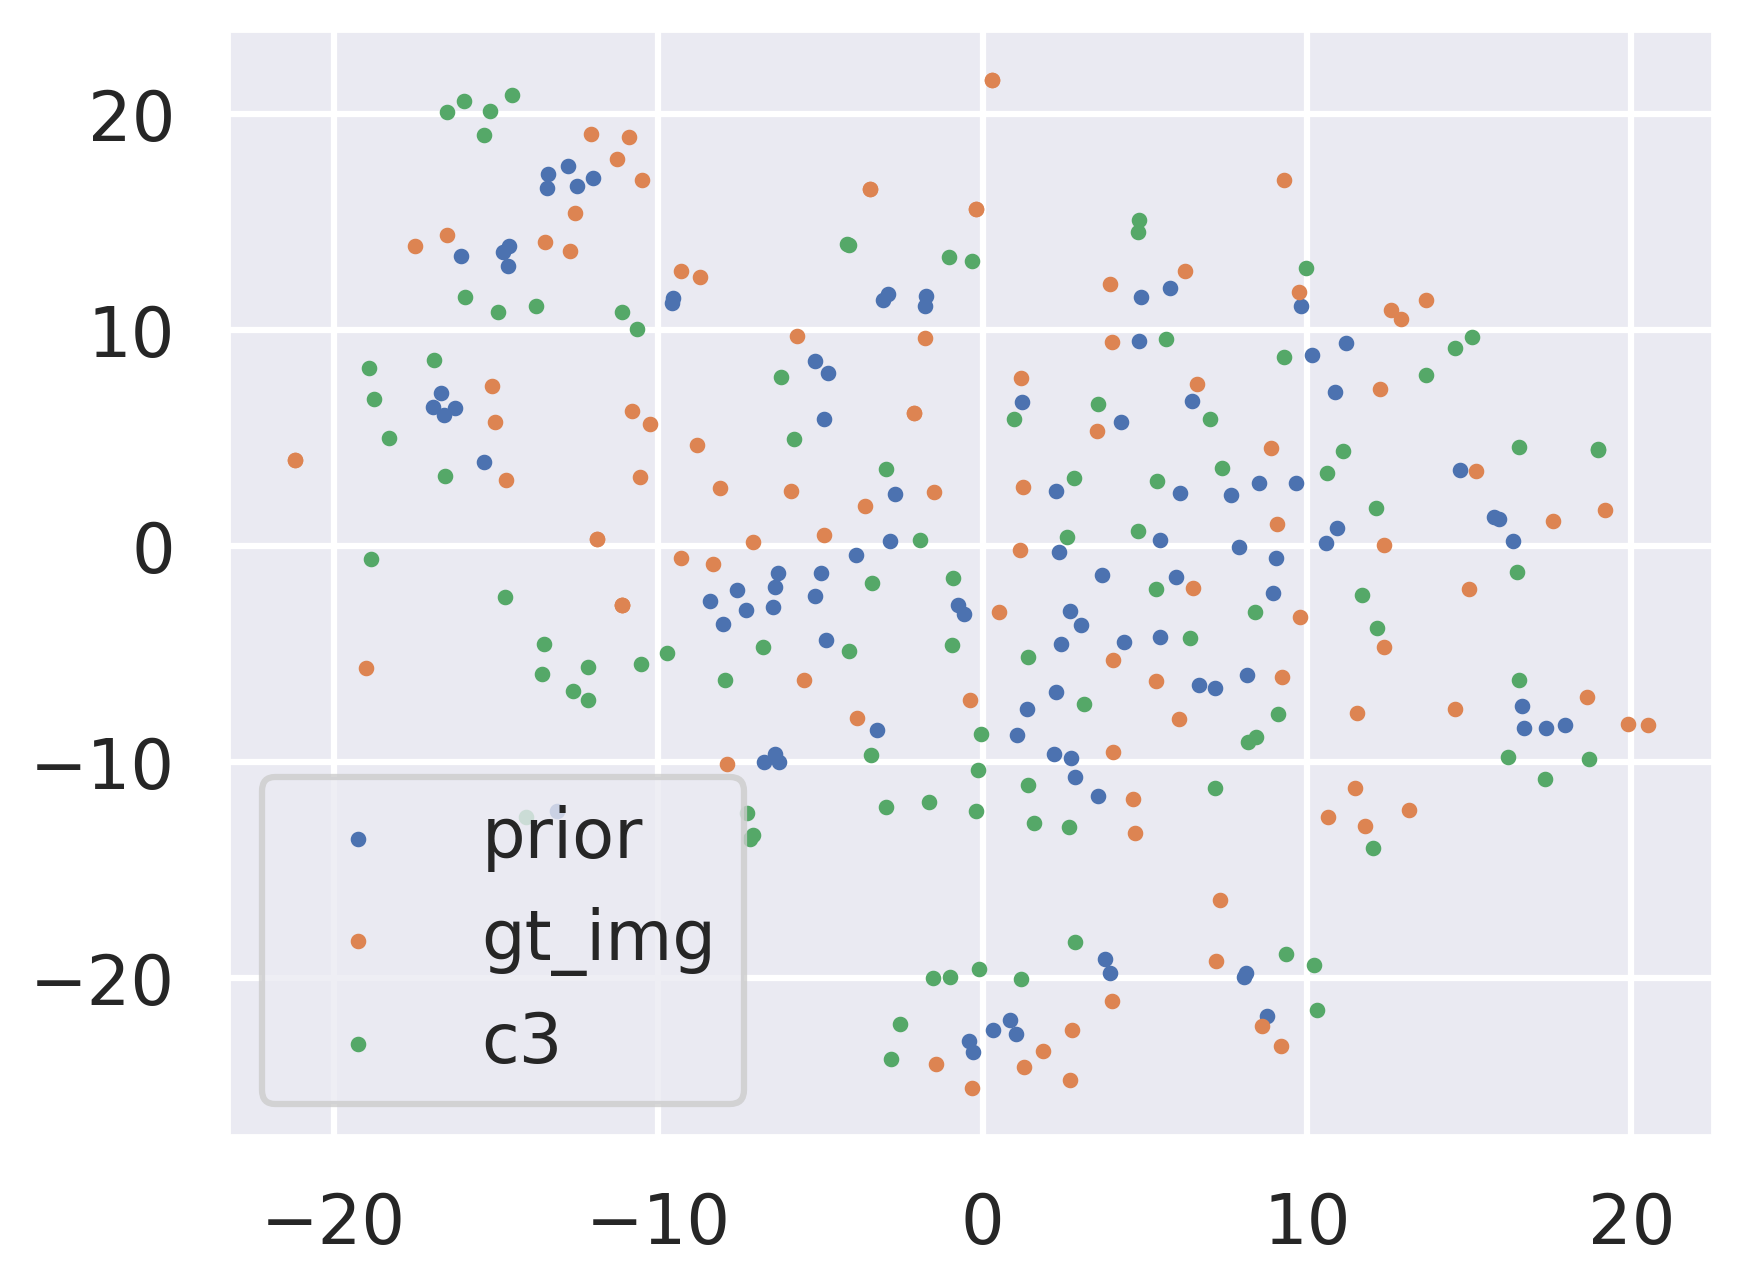

In [80]:
def get_embeddings(noise_level=0.01):
    prior_embeds = []
    img_embeds = []
    pseudo_img_embeds_c1 = []
    pseudo_img_embeds_c2_1 = []
    pseudo_img_embeds_c2_2 = []
    pseudo_img_embeds_c3 = []
    
    for cap_id, prior_dict in all_prior_embed_outputs['diffusion_prior_outputs'].items():
        # Prior output embed
        prior_embed = prior_dict['avg_embed']
        prior_embed = prior_embed / prior_embed.norm()
        prior_embeds.append(prior_embed)
        
        # GT image embed
        img_id = captions[cap_id]['img_id']
        img_embed = images[img_id]['embed'].squeeze()
        img_embed = img_embed / img_embed.norm()
        img_embeds.append(img_embed)
        
        # Pseudo image embed (from text)
        pseudo_img_embed = captions[cap_id]['embed']
        pseudo_img_embed = (pseudo_img_embed / pseudo_img_embed.norm()).squeeze()
        pseudo_img_embeds_c1.append(pseudo_img_embed)

        # Remove gap
        pseudo_img_embed_remove_gap = pseudo_img_embed + modality_gap.squeeze()
        pseudo_img_embeds_c2_1.append(pseudo_img_embed_remove_gap / pseudo_img_embed_remove_gap.norm())

        # Add noise
        noise = torch.randn(pseudo_img_embed.shape[0]) * noise_level
        pseudo_img_embed_add_noise = pseudo_img_embed + noise
        pseudo_img_embeds_c2_2.append(pseudo_img_embed_add_noise / pseudo_img_embed_add_noise.norm())
        
        # C3
        pseudo_img_embed_c3 = pseudo_img_embed_remove_gap + noise
        pseudo_img_embeds_c3.append(pseudo_img_embed_c3 / pseudo_img_embed_c3.norm())
        
    return {
        "prior": prior_embeds, 
        "gt_img": img_embeds, 
        # "c1": pseudo_img_embeds_c1, 
        # "c2_1": pseudo_img_embeds_c2_1,
        # "c2_2": pseudo_img_embeds_c2_2,
        "c3": pseudo_img_embeds_c3
    }
    

tsne = TSNE()

n = len(all_prior_embed_outputs['diffusion_prior_outputs'])
all_embeds_dict = get_embeddings()
embeds_stack = []

mapping = {key:idx for idx, key in enumerate(all_embeds_dict)}

for key in mapping:
    embeds_stack.extend(all_embeds_dict[key])

embeds = torch.vstack(embeds_stack)
two_dimensional_embeds = tsne.fit_transform(embeds)

plt.clf()
plt.figure()

for key, idx in mapping.items():
    plt.scatter(two_dimensional_embeds[n*idx:n*(idx+1), 0], two_dimensional_embeds[n*idx:n*(idx+1), 1], label=key, s=5)

plt.legend()
plt.show()
    